In [13]:
import numpy as np
import matplotlib as mat
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import multivelo as mv
scv.__version__

'0.3.1'

In [33]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
np.set_printoptions(suppress=True)

In [3]:
#Preprocessing the ATAC 

sampleID = ['Macaque_M1_PFC','Macaque_M2_PFC']

i = 0
for sample in sampleID: 
    i = i+1
    matrix_path = f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/filtered_feature_bc_matrix/'
    print(f'reading ATAC input from the mtx path : {matrix_path}')
    adata_atac = sc.read_10x_mtx(matrix_path, var_names='gene_symbols', cache=True, gex_only=False)
    adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]
    adata_atac = mv.aggregate_peaks_10x(adata_atac,
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/peak_annotation.tsv',
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/analysis/feature_linkage/feature_linkage.bedpe',
                                    verbose=True)
    mv.tfidf_norm(adata_atac)
    # subset the annotated cells from ATAC assay 
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/{sample}_celltype_annotation'
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    shared_cells_anno = pd.Index(np.intersect1d(adata_atac.obs_names, cell_annot.index))
    adata_atac = adata_atac[shared_cells_anno,:]
       adata_atac.obs_names = [f'{sample}_' + x for x in adata_atac.obs_names]
    adata_atac.var_names_make_unique()

    if i == 1: adata_atac_all = adata_atac
    
    if i > 1:
        adata_atac_all = adata_atac_all.concatenate(adata_atac)

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M1_PFC/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13117 genes with promoter peaks


  0%|          | 0/13117 [00:00<?, ?it/s]

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M2_PFC/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13464 genes with promoter peaks


  0%|          | 0/13464 [00:00<?, ?it/s]

In [4]:
### rename the index (cellid) after concatenation
adata_atac_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_atac_all.obs_names]

In [5]:
adata_atac_all

AnnData object with n_obs × n_vars = 20260 × 12858
    obs: 'batch'

In [6]:
adata_atac_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_ATAC_raw.h5ad')

In [7]:
sampleID = ['Macaque_M1_PFC','Macaque_M2_PFC']

i = 0
for sample in sampleID: 
    i = i+1
    loom_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/{sample}.loom'
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/{sample}_celltype_annotation'
    print(f'loom file path is {loom_path}')
    print(f'cell annotation file path is {cell_anno_path}')
    adata_rna = scv.read(loom_path, cache=True)
    adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    ## subset annotated cells from RNA assay
    shared_cells_anno = pd.Index(np.intersect1d(adata_rna.obs_names, cell_annot.index))
    adata_rna = adata_rna[shared_cells_anno,:]
    ## assign celltypes
    adata_rna.obs['celltype'] = cell_annot['celltype']
    ### rename cells with sampleID
    adata_rna.obs_names = [f'{sample}_' + x for x in adata_rna.obs_names]
    adata_rna.var_names_make_unique()
      if i == 1: adata_rna_all = adata_rna
    
    if i > 1:
        adata_rna_all = adata_rna_all.concatenate(adata_rna)


loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M1_PFC.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M1_PFC_celltype_annotation
loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M2_PFC.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M2_PFC_celltype_annotation


In [8]:
### rename the index (cellid) after concatenation
adata_rna_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_rna_all.obs_names]

In [10]:
adata_rna_all

AnnData object with n_obs × n_vars = 20260 × 34884
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [9]:
adata_rna_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_RNA_raw.h5ad')

In [11]:
scv.pp.filter_and_normalize(adata_rna_all, min_shared_counts=10)

Filtered out 24495 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [12]:
adata_rna_all

AnnData object with n_obs × n_vars = 20260 × 10389
    obs: 'celltype', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'log1p'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
shared_cells = pd.Index(np.intersect1d(adata_rna_all.obs_names, adata_atac_all.obs_names))
shared_genes_assay = pd.Index(np.intersect1d(adata_rna_all.var_names, adata_atac_all.var_names))

In [14]:
len(shared_cells), len(shared_genes_assay)

(20260, 8860)

In [15]:
shared_genes_assay

Index(['AACS', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AAR2', 'AARS1',
       'AARS2', 'AASDHPPT',
       ...
       'ZSWIM6', 'ZSWIM7', 'ZSWIM8', 'ZUP1', 'ZW10', 'ZWILCH', 'ZXDC',
       'ZYG11B', 'ZYX', 'ZZEF1'],
      dtype='object', length=8860)

In [16]:
## import the genes tested for dPSI
PSI_genes = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/delta_PSI_PFCvsVIS/Macaque_broad_Celltypes_deltaPSI_tested_GeneNames.txt", header=None)[0])

In [17]:
PSI_genes

Index(['AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCC10', 'ABCE1', 'ABCF3', 'ABHD12',
       'ABHD6', 'ABI1',
       ...
       'ZNF414', 'ZNF484', 'ZNF532', 'ZNF568', 'ZNF638', 'ZNF711', 'ZRANB3',
       'ZSWIM7', 'ZYX', 'ensembl'],
      dtype='object', name=0, length=1571)

In [18]:
## find the shared genes between RNA-ATAC assays and dPSI tested genes
shared_genes = pd.Index(np.intersect1d(shared_genes_assay, PSI_genes))

In [19]:
shared_genes

Index(['AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCC10', 'ABCE1', 'ABCF3', 'ABHD12',
       'ABHD6', 'ABI1',
       ...
       'ZNF37A', 'ZNF410', 'ZNF414', 'ZNF484', 'ZNF568', 'ZNF638', 'ZNF711',
       'ZRANB3', 'ZSWIM7', 'ZYX'],
      dtype='object', length=1415)

In [20]:
adata_rna_all = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_RNA_raw.h5ad')

In [21]:
## subset the shared_cells and shared_genes from whole assay
adata_rna = adata_rna_all[shared_cells, shared_genes]

In [22]:
adata_rna

View of AnnData object with n_obs × n_vars = 20260 × 1415
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [23]:
adata_rna.var_names_make_unique()

In [24]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)

Normalized count data: X, spliced, unspliced.


/tmp/ipykernel_94503/2089892543.py:2: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


In [25]:
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

computing neighbors
    finished (0:00:24) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [26]:
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [27]:
set(adata_rna.obs['celltype'])

{'Astrocytes',
 'Endothelial',
 'Excitatory_Neurons',
 'Inhibitory_Neurons',
 'Microglia',
 'OPCs',
 'Oligodendrocytes'}

In [28]:
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['Astrocytes',
                                                      'Excitatory_Neurons',
                                                      'Inhibitory_Neurons',
                                                      'Microglia',
                                                      'Oligodendrocytes',
                                                      'OPCs'])]

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_spliced.unpliced_proportions_dPSIgenes.pdf


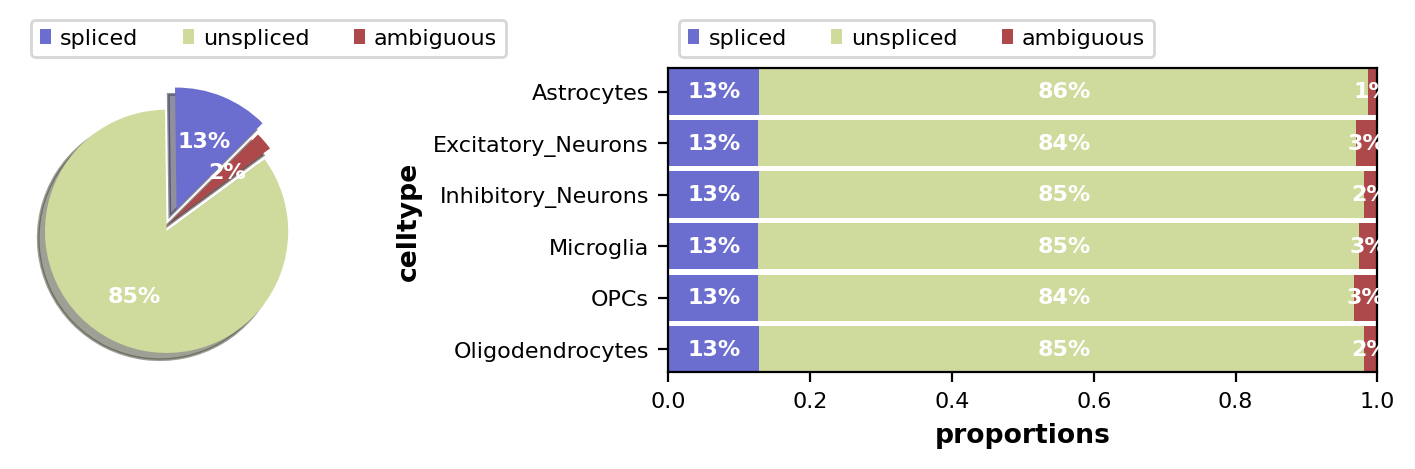

In [29]:
scv.pl.proportions(adata_rna, groupby='celltype',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_spliced.unpliced_proportions_dPSIgenes.pdf' )

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna_umap_dPSI_genes.pdf


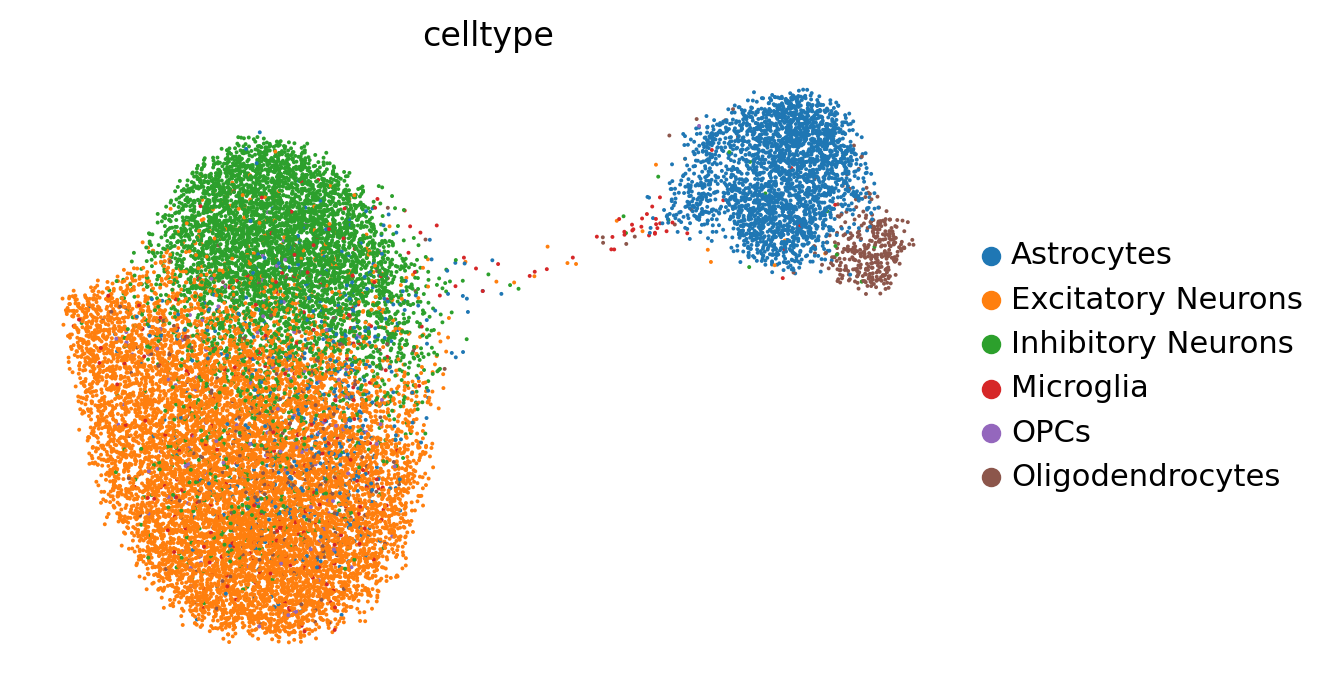

In [30]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype',size = 8, legend_loc='right margin',save = "/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna_umap_dPSI_genes.pdf")

In [31]:
adata_rna.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna.dPSIgenes.celltype.filtered_normalized.h5ad')

In [32]:
adata_atac

AnnData object with n_obs × n_vars = 12910 × 13464

In [33]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_PFC_nn_cells.txt", header=None)[0])

In [34]:
adata_atac_all.obs_names

Index(['Macaque_M1_PFC_AAACAGCCAAACTCAT-1',
       'Macaque_M1_PFC_AAACAGCCAATTAACC-1',
       'Macaque_M1_PFC_AAACAGCCACATACTG-1',
       'Macaque_M1_PFC_AAACAGCCAGTTAAAG-1',
       'Macaque_M1_PFC_AAACAGCCATAAGTTC-1',
       'Macaque_M1_PFC_AAACAGCCATAGCAGG-1',
       'Macaque_M1_PFC_AAACATGCATAATTGC-1',
       'Macaque_M1_PFC_AAACCAACAACTGGCT-1',
       'Macaque_M1_PFC_AAACCGAAGATAGACG-1',
       'Macaque_M1_PFC_AAACCGAAGCGGATTT-1',
       ...
       'Macaque_M2_PFC_TTTGTTGGTAATCCCT-1',
       'Macaque_M2_PFC_TTTGTTGGTATTGTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTCGAAGTC-1',
       'Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1',
       'Macaque_M2_PFC_TTTGTTGGTGCTTTAC-1',
       'Macaque_M2_PFC_TTTGTTGGTGTCACGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTGCATCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTTACTTG-1'],
      dtype='object', length=20260)

In [35]:
np.all(nn_cells == adata_atac_all.obs_names)

True

In [36]:
adata_atac_all

AnnData object with n_obs × n_vars = 20260 × 12858
    obs: 'batch'

In [37]:
mv.knn_smooth_chrom(adata_atac_all, nn_idx, nn_dist)

In [38]:
shared_cells_new = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac_all.obs_names))

In [39]:
shared_cells_new

Index(['Macaque_M1_PFC_AAACAGCCAAACTCAT-1',
       'Macaque_M1_PFC_AAACAGCCAATTAACC-1',
       'Macaque_M1_PFC_AAACAGCCACATACTG-1',
       'Macaque_M1_PFC_AAACAGCCAGTTAAAG-1',
       'Macaque_M1_PFC_AAACAGCCATAAGTTC-1',
       'Macaque_M1_PFC_AAACAGCCATAGCAGG-1',
       'Macaque_M1_PFC_AAACATGCATAATTGC-1',
       'Macaque_M1_PFC_AAACCAACAACTGGCT-1',
       'Macaque_M1_PFC_AAACCGAAGATAGACG-1',
       'Macaque_M1_PFC_AAACCGAAGCGGATTT-1',
       ...
       'Macaque_M2_PFC_TTTGTTGGTAATCCCT-1',
       'Macaque_M2_PFC_TTTGTTGGTATTGTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTCGAAGTC-1',
       'Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1',
       'Macaque_M2_PFC_TTTGTTGGTGCTTTAC-1',
       'Macaque_M2_PFC_TTTGTTGGTGTCACGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1',
       'Macaque_M2_PFC_TTTGTTGGTTGCATCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1',
       'Macaque_M2_PFC_TTTGTTGGTTTACTTG-1'],
      dtype='object', length=19856)

In [40]:
adata_atac = adata_atac_all[shared_cells_new, shared_genes]

In [41]:
adata_atac.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_atac.dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [3]:
adata_atac = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_atac.dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [4]:
adata_rna = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_adata_rna.dPSIgenes.celltype.filtered_normalized.h5ad')

In [5]:
adata_rna

AnnData object with n_obs × n_vars = 19856 × 1415
    obs: 'celltype', 'batch', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
adata_atac

AnnData object with n_obs × n_vars = 19856 × 1415
    obs: 'batch'
    layers: 'Mc'
    obsp: 'connectivities'

In [7]:
# This will take a while. Parallelization is high recommended.
#mv.settings.VERBOSITY = 0
adata_result = mv.recover_dynamics_chrom(adata_rna,
                                         adata_atac,
                                         max_iter=5,
                                         init_mode="invert",
                                         parallel=True,
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500,
                                         extra_color_key='celltype'
                                        )

  0%|          | 0/1415 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed s

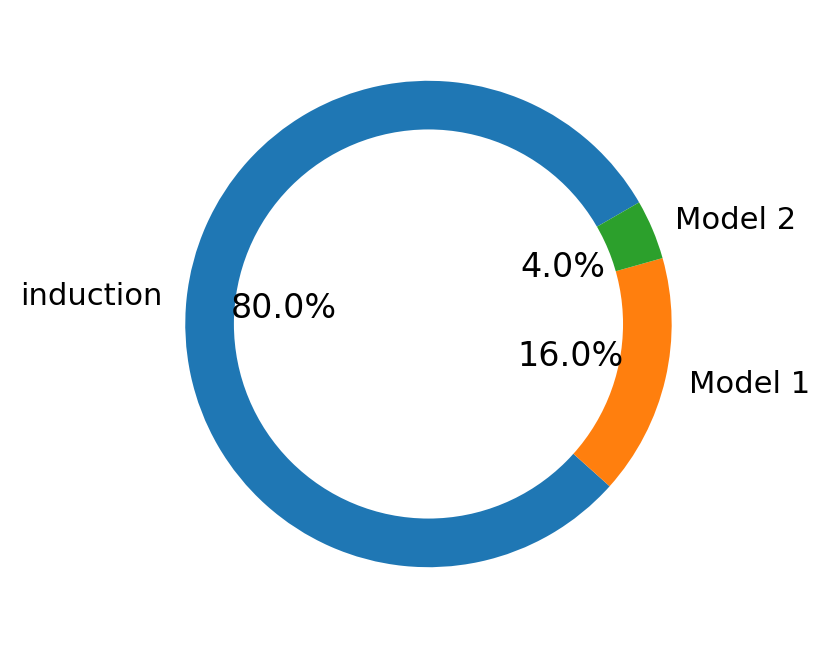

In [8]:
mv.pie_summary(adata_result)

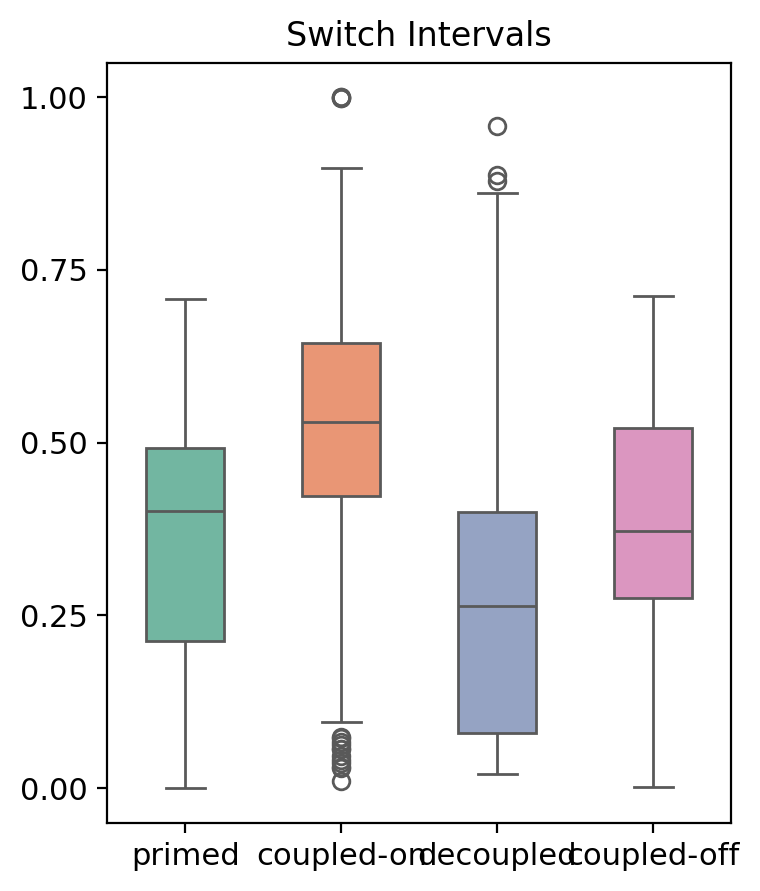

In [9]:
mv.switch_time_summary(adata_result)

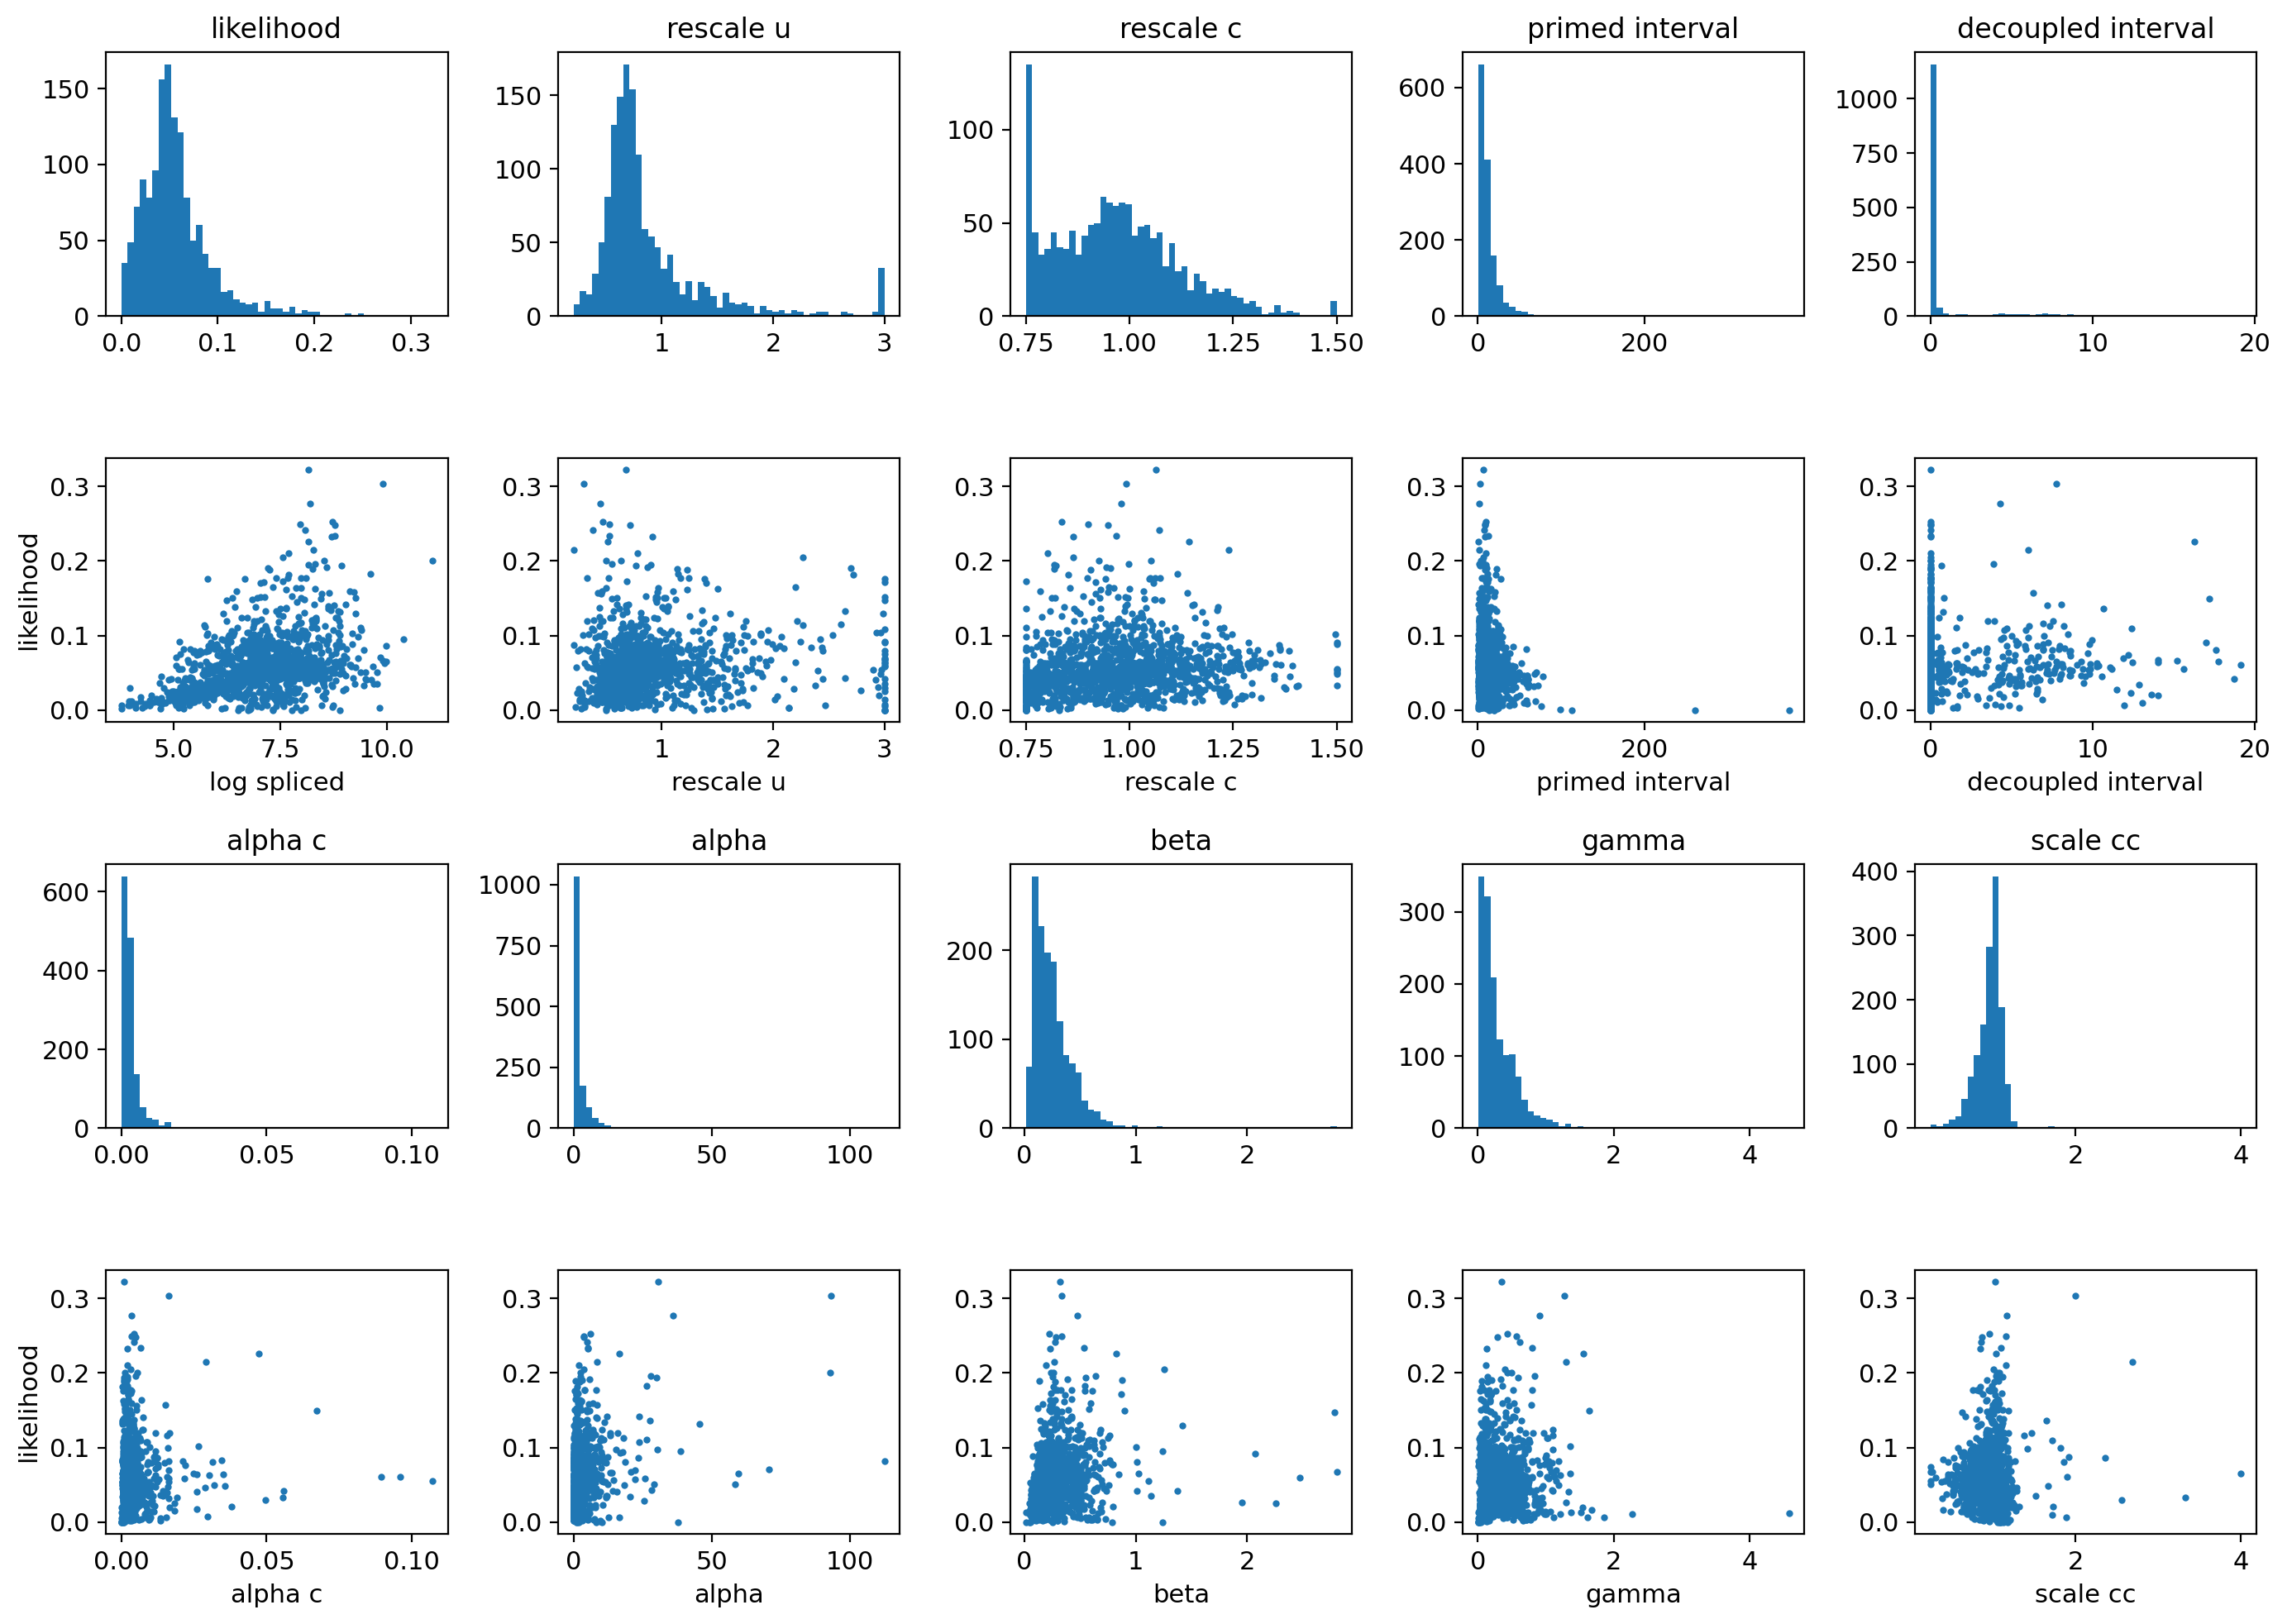

In [10]:
mv.likelihood_plot(adata_result)

In [11]:
#Computing velocity stream and latent time
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/56 cores)


  0%|          | 0/19856 [00:00<?, ?cells/s]

    finished (0:01:03) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 10 regions of root cells and 2 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:05) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:06) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_dPSItested_genes.png


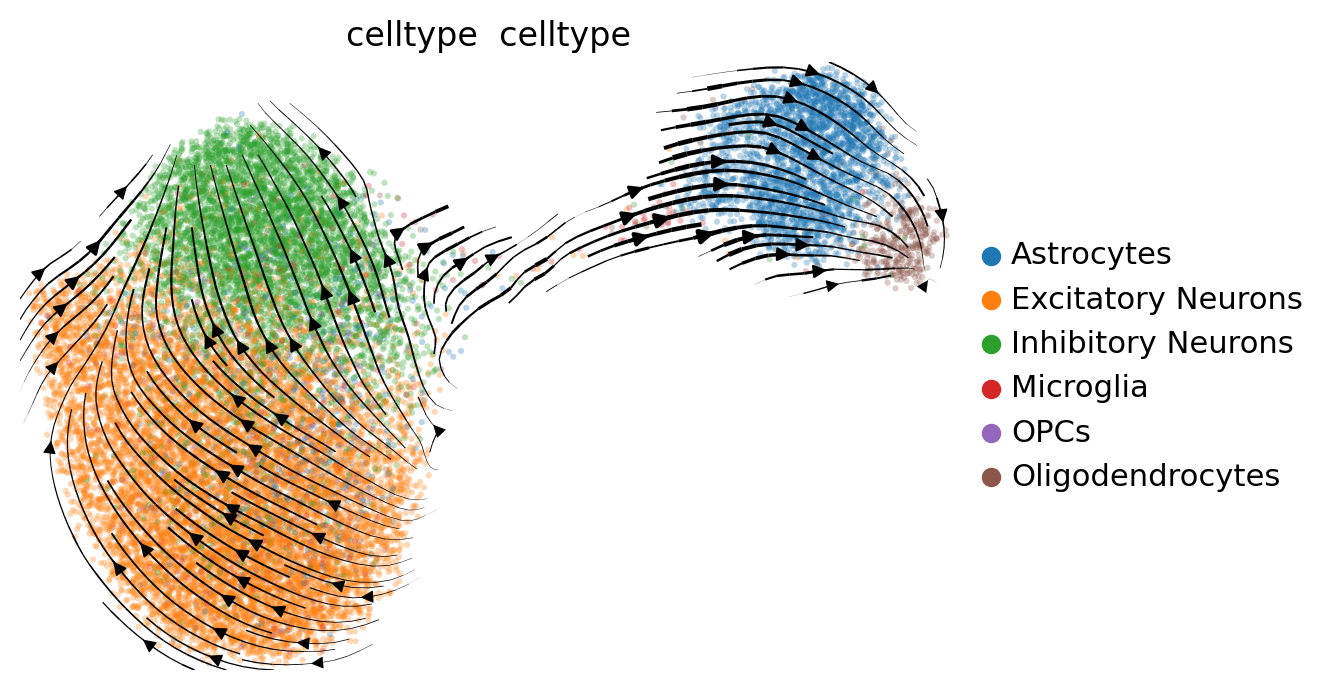

In [12]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype',size = 20, legend_loc='right margin',layer='celltype', save = '/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_dPSItested_genes.pdf')

In [13]:
### add sampleID 
adata_result.obs['IndividualID'] = [x.split('_')[1][:] for x in adata_result.obs_names]
adata_result.obs['Region'] = [x.split('_')[2][:] for x in adata_result.obs_names]
#adata_result.obs['SampleID'] = f'adata_result.obs['IndividualID']_adata_result.obs['Region']'

In [14]:
adata_result.obs['SampleID'] = adata_result.obs['IndividualID'].astype(str) + adata_result.obs['Region']

In [15]:
adata_result.obs

celltype batch    n_counts  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1          Astrocytes     0  147.000000   
Macaque_M1_PFC_AAACAGCCAATTAACC-1  Inhibitory_Neurons     0  147.000015   
Macaque_M1_PFC_AAACAGCCACATACTG-1  Inhibitory_Neurons     0  147.000061   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1  Excitatory_Neurons     0  147.000000   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1  Excitatory_Neurons     0  146.999985   
...                                               ...   ...         ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1  Excitatory_Neurons     1  147.000000   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1  Excitatory_Neurons     1  146.999969   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1          Astrocytes     1  146.999985   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1  Inhibitory_Neurons     1  147.000015   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1  Inhibitory_Neurons     1  146.999985   

                                   velo_s_norm_self_transition  root_cells  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1                     0.120728    0.011847   
Macaque_M1_PFC_AAACAGCCAATTAACC-1                     0.299343    1.000000   
Macaque_M1_PFC_AAACAGCCACATACTG-1                     0.293888    0.095504   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1                     0.261346    0.009567   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1                     0.295445    0.011704   
...                                                        ...         ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1                     0.279718    0.121196   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1                     0.258743    0.040453   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1                     0.058462    0.103739   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1                     0.262753    0.019037   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1                     0.284339    0.036638   

                                   end_points  velo_s_norm_pseudotime  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1    0.308563                0.035277   
Macaque_M1_PFC_AAACAGCCAATTAACC-1    0.000000                0.722162   
Macaque_M1_PFC_AAACAGCCACATACTG-1    0.121308                0.858129   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1    0.580081                0.978803   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1    0.890053                0.944121   
...                                       ...                     ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1    0.166957                0.885419   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1    0.313106                0.897685   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1    0.117295                0.028509   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1    0.645524                0.839971   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1    0.243721                0.892915   

                                   latent_time IndividualID Region SampleID  
Macaque_M1_PFC_AAACAGCCAAACTCAT-1     0.060606           M1    PFC    M1PFC  
Macaque_M1_PFC_AAACAGCCAATTAACC-1     0.591478           M1    PFC    M1PFC  
Macaque_M1_PFC_AAACAGCCACATACTG-1     0.734228           M1    PFC    M1PFC  
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1     0.889818           M1    PFC    M1PFC  
Macaque_M1_PFC_AAACAGCCATAAGTTC-1     0.838290           M1    PFC    M1PFC  
...                                        ...          ...    ...      ...  
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1     0.840819           M2    PFC    M2PFC  
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1     0.897819           M2    PFC    M2PFC  
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1     0.055885           M2    PFC    M2PFC  
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1     0.782355           M2    PFC    M2PFC  
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1     0.843614           M2    PFC    M2PFC  

[19856 rows x 11 columns]

figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_dPSItested_genes_bySampleID.png


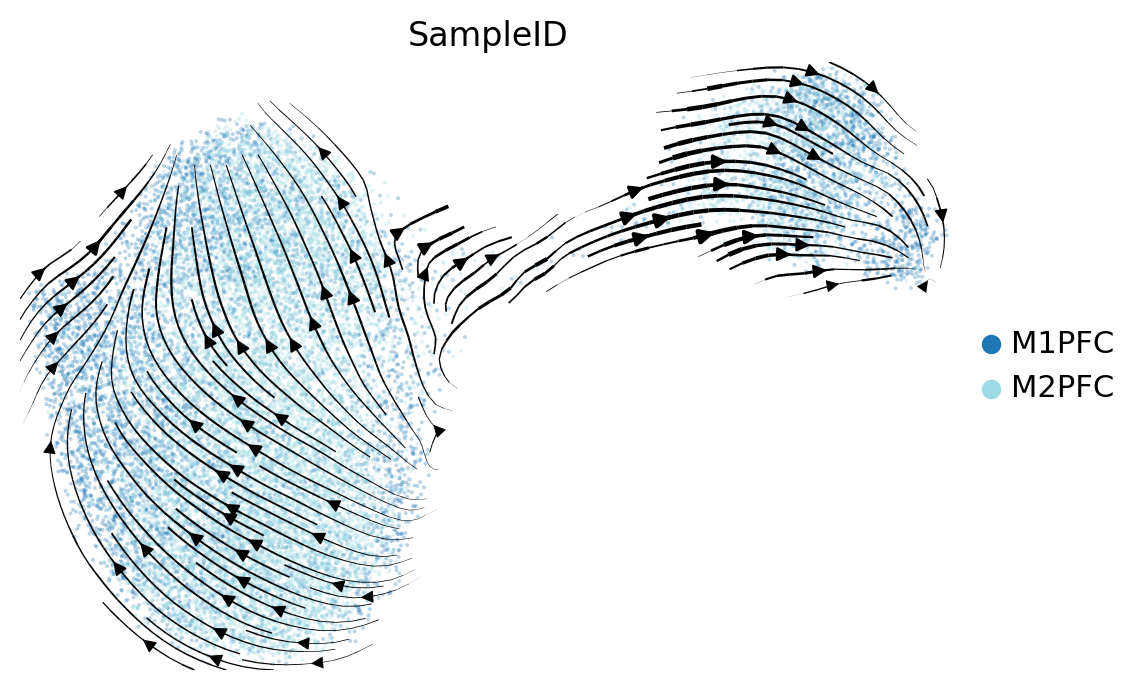

In [16]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='SampleID',palette='tab20',colorbar=True, size = 8, legend_loc='right margin',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_velocity_stream_dPSItested_genes_bySampleID.pdf')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/56 cores)


  0%|          | 0/19856 [00:00<?, ?cells/s]

    finished (0:01:14) --> added 
    'velo_chrom_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:06) --> added
    'velo_chrom_norm_umap', embedded velocity vectors (adata.obsm)


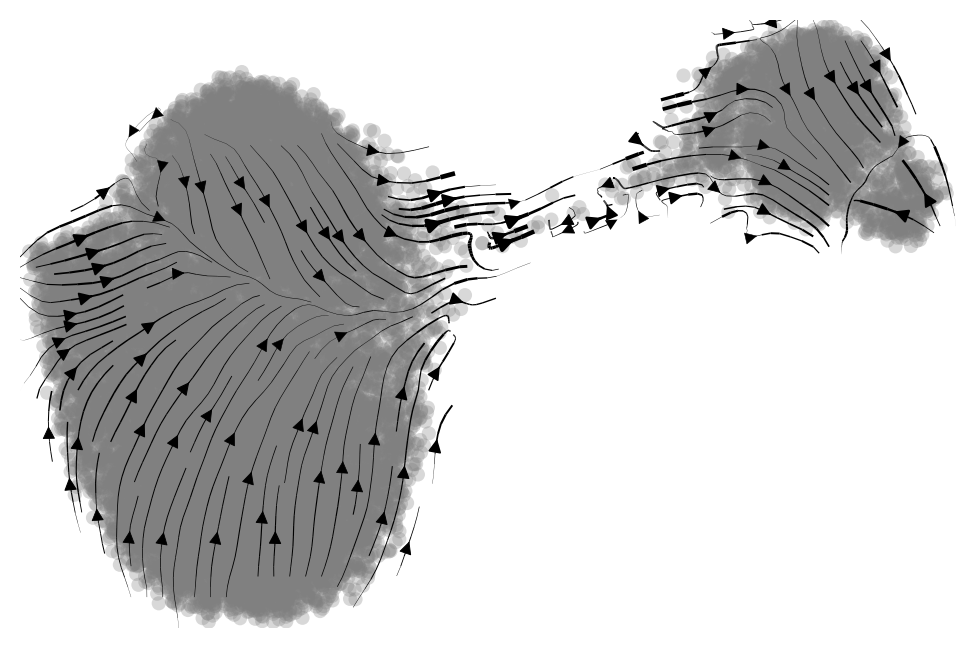

In [17]:
# velocity by atac
mv.velocity_embedding_stream(adata_result, basis='umap',vkey='velo_chrom')

figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_ATAC_velocity_stream_dPSItested_genes_byCelltype.png


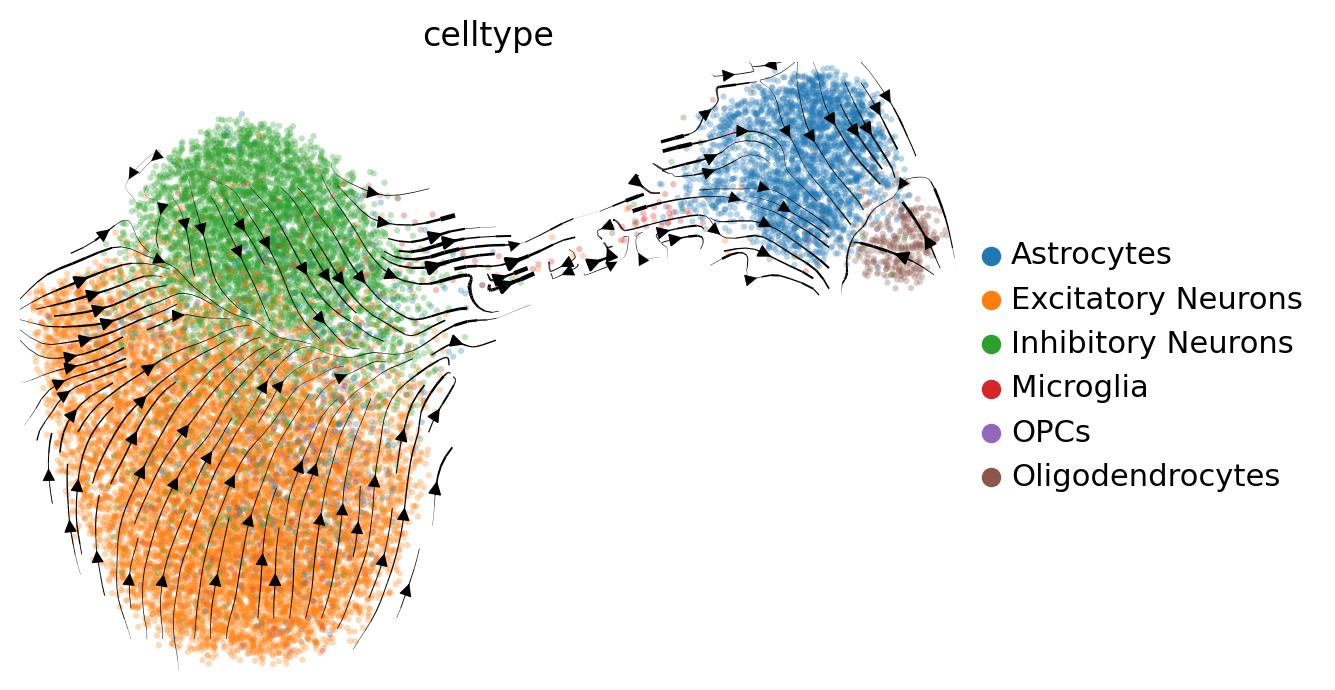

In [18]:
# plot velocity stream by velo_chrom
mv.velocity_embedding_stream(adata_result,color='celltype',size = 20, legend_loc='right margin', basis='umap',vkey='velo_chrom',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_ATAC_velocity_stream_dPSItested_genes_byCelltype.pdf')

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_latentTime.pdf


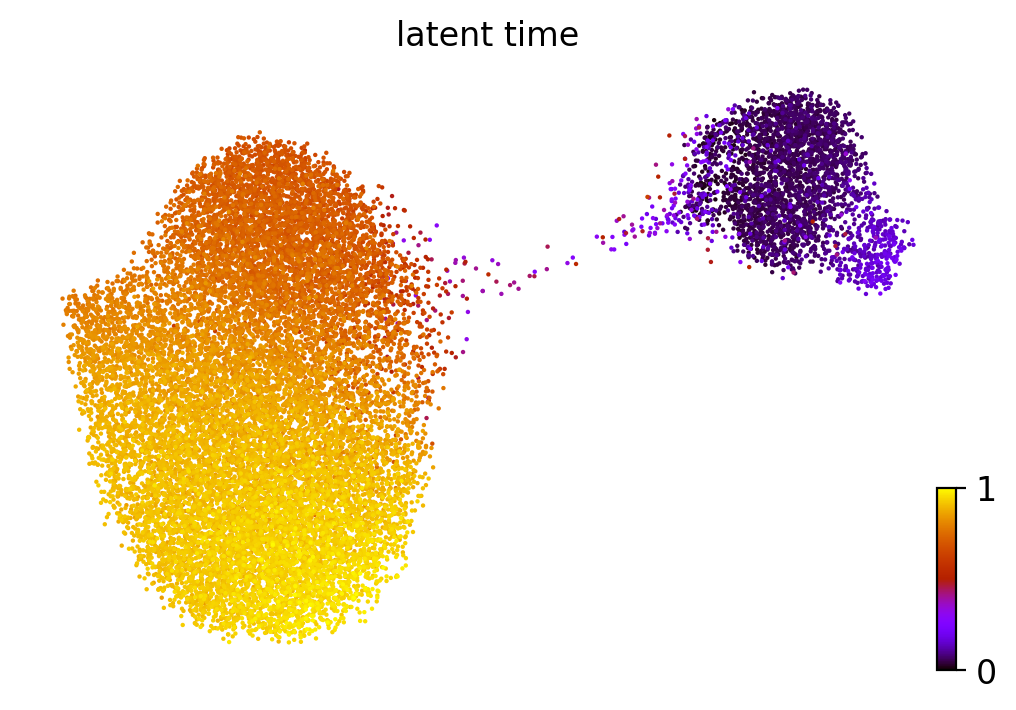

In [19]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=10,save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_latentTime.pdf')

In [20]:
# Save the result for use later on
adata_result.write("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_dPSItestedGenes.h5ad")

In [22]:
adata_result = sc.read_h5ad("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_dPSItestedGenes.h5ad")

In [23]:
adata_result_exn = adata_result[adata_result.obs['celltype'] == "Excitatory_Neurons"]

In [24]:
adata_result_exn.obs

celltype batch    n_counts  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1  Excitatory_Neurons     0  147.000000   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1  Excitatory_Neurons     0  146.999985   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1  Excitatory_Neurons     0  147.000000   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1  Excitatory_Neurons     0  146.999969   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1  Excitatory_Neurons     0  146.999985   
...                                               ...   ...         ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1  Excitatory_Neurons     1  147.000000   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1  Excitatory_Neurons     1  147.000000   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1  Excitatory_Neurons     1  147.000031   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1  Excitatory_Neurons     1  147.000000   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1  Excitatory_Neurons     1  146.999969   

                                   velo_s_norm_self_transition  root_cells  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1                     0.261346    0.009567   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1                     0.295445    0.011704   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1                     0.253551    0.023060   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1                     0.276284    0.019803   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1                     0.312447    0.022637   
...                                                        ...         ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1                     0.265142    0.213384   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1                     0.280151    0.184232   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1                     0.301899    0.120822   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1                     0.279718    0.121196   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1                     0.258743    0.040453   

                                   end_points  velo_s_norm_pseudotime  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1    0.580081                0.978803   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1    0.890053                0.944121   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1    0.472043                0.914699   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1    0.750794                0.921206   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1    0.269807                0.972089   
...                                       ...                     ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1    0.100294                0.876734   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1    0.052241                0.881484   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1    0.139507                0.897213   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1    0.166957                0.885419   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1    0.313106                0.897685   

                                   latent_time IndividualID Region SampleID  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1     0.889818           M1    PFC    M1PFC   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1     0.838290           M1    PFC    M1PFC   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1     0.862307           M1    PFC    M1PFC   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1     0.925998           M1    PFC    M1PFC   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1     0.847463           M1    PFC    M1PFC   
...                                        ...          ...    ...      ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1     0.791061           M2    PFC    M2PFC   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1     0.864143           M2    PFC    M2PFC   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1     0.838805           M2    PFC    M2PFC   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1     0.840819           M2    PFC    M2PFC   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1     0.897819           M2    PFC    M2PFC   

                                   velo_chrom_norm_self_transition  
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1                         0.021067  
Macaque_M1_PFC_AAACAGCCATAAGTTC-1                         0.042828  
Macaque_M1_PFC_AAACCGAAGCGGATTT-1                         0.018121  
Macaque_M1_PFC_AAACCGAAGTTGGATC-1                         0.022984  
Macaque_M1_PFC_AAACCGCGTAAGCACC-1   

In [25]:
exn_cells = adata_result_exn.obs.index
dPSI_filter_genes = adata_result.var.index
state_exn = adata_result[exn_cells,dPSI_filter_genes].layers['fit_state']
state_exn_df = pd.DataFrame(state_exn)
state_exn_df.index = exn_cells
state_exn_df.columns = dPSI_filter_genes

In [26]:
state_exn_df

Gene                               AAK1  AATK  ABAT  ABCA5  ABCC10  ABCE1  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1   1.0   1.0   1.0    2.0     1.0    1.0   
...                                 ...   ...   ...    ...     ...    ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1   1.0   1.0   1.0    2.0     1.0    1.0   

Gene                               ABCF3  ABHD12  ABHD6  ABI1  ...  ZNF37A  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1    1.0     1.0    1.0   2.0  ...     1.0   
...                                  ...     ...    ...   ...  ...     ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1    1.0     1.0    1.0   2.0  ...     1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1    1.0     1.0    1.0   2.0  ...     1.0   

Gene                               ZNF410  ZNF414  ZNF484  ZNF568  ZNF638  \
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M1_PFC_AAACCGAAGCGGATTT-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M1_PFC_AAACCGAAGTTGGATC-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M1_PFC_AAACCGCGTAAGCACC-1     1.0     1.0     1.0     1.0     1.0   
...                                   ...     ...     ...     ...     ...   
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1     1.0     1.0     1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1     1.0     1.0     1.0     1.0     1.0   

Gene                               ZNF711  ZRANB3  ZSWIM7  ZYX  
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1     1.0     1.0     1.0  1.0  
Macaque_M1_PFC_AAACAGCCATAAGTTC-1     1.0     1.0     1.0  1.0  
Macaque_M1_PFC_AAACCGAAGCGGATTT-1     1.0     1.0     1.0  1.0  
Macaque_M1_PFC_AAACCGAAGTTGGATC-1     1.0     1.0     1.0  1.0  
Macaque_M1_PFC_AAACCGCGTAAGCACC-1     1.0     1.0     1.0  1.0  
...                                   ...     ...     ...  ...  
Macaque_M2_PFC_TTTGTTGGTAATCCCT-1     1.0     1.0     1.0  1.0  
Macaque_M2_PFC_TTTGTTGGTATTGTGG-1     1.0     1.0     1.0  1.0  
Macaque_M2_PFC_TTTGTTGGTCTAGCTT-1     1.0     1.0     1.0  1.0  
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1     1.0     1.0     1.0  1.0  
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1     1.0     1.0     1.0  1.0  

[10419 rows x 1413 columns]

In [20]:
state_exn_pair = state_exn_df.stack()

In [21]:
state_exn_pair

                                   Gene  
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1  AAK1      1.0
                                   AATK      1.0
                                   ABAT      1.0
                                   ABCA5     2.0
                                   ABCC10    1.0
                                            ... 
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1  ZNF638    1.0
                                   ZNF711    1.0
                                   ZRANB3    1.0
                                   ZSWIM7    1.0
                                   ZYX       1.0
Length: 14722047, dtype: float64

In [27]:
# save the state matrix, index = cellID, header = geneName
state_exn_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_region.comparison_dPSItestedGenes_ExN_Cell_States_mtx.csv')

In [21]:
unique_fit_model = set(adata_result.var['fit_model'])

In [22]:
# get the model 1 genes
adata1 = adata_result[:, adata_result.var['fit_model'].values == 1]
# get the model 2 genes
adata2 = adata_result[:, adata_result.var['fit_model'].values == 2]

In [23]:
adata1.var

Accession Chromosome        End      Start Strand  \
Gene                                                                 
AAK1    ENSMMUG00000007868         13   39340248   39160062      +   
AATK    ENSMMUG00000015514         16   77499815   77452417      -   
ABAT    ENSMMUG00000046237         20    8825602    8716480      +   
ABCA5   ENSMMUG00000018608         16   65636081   65557549      -   
ABCC10  ENSMMUG00000015569          4  125904949  125858539      -   
...                    ...        ...        ...        ...    ...   
ZNF638  ENSMMUG00000007175         13   37515040   37361042      -   
ZNF711  ENSMMUG00000013603          X   82141545   82116221      +   
ZRANB3  ENSMMUG00000000765         12   20679677   20375415      -   
ZSWIM7  ENSMMUG00000030294         16   16420666   16398382      +   
ZYX     ENSMMUG00000012635          3  169986921  169975486      +   

        fit_alpha_c  fit_alpha  fit_beta  fit_gamma  fit_t_sw1  fit_t_sw2  \
Gene                                                                        
AAK1       0.004890   2.016786  0.115171   0.254131  -1.205121  20.128185   
AATK       0.006778   2.765183  0.377106   0.448240  -0.472527  20.025170   
ABAT       0.001634   3.726659  0.323771   0.355641  -0.037997  20.016303   
ABCA5      0.016467   7.375373  0.504754   0.813367   1.697450   3.613982   
ABCC10     0.001384   2.514303  0.372497   0.276765  -0.012212  20.051390   
...             ...        ...       ...        ...        ...        ...   
ZNF638     0.002594   3.685006  0.333869   0.359560  -3.899380  19.385185   
ZNF711     0.001497   0.216954  0.116244   0.031025  -0.068816  20.028088   
ZRANB3     0.001282   0.234844  0.068272   0.187300  -0.027486  20.019829   
ZSWIM7     0.004484   0.046507  0.200365   0.026445  -0.042638  20.053534   
ZYX        0.003694   0.762034  0.273390   0.073540  -0.001659  20.033341   

        fit_t_sw3  fit_scale_cc  fit_rescale_c  fit_rescale_u  \
Gene                                                            
AAK1    62.837838      0.960597       0.827455       0.485524   
AATK    20.639269      0.974223       0.998571       0.495596   
ABAT    22.857143      0.897979       1.135067       0.722584   
ABCA5    7.174245      1.138716       1.011406       0.457741   
ABCC10  20.862069      0.829005       1.171923       0.784132   
...           ...           ...            ...            ...   
ZNF638  20.000000      1.041155       1.000181       0.529036   
ZNF711  23.140496      0.623212       1.154160       0.843195   
ZRANB3  96.619718      1.080721       0.756278       0.661382   
ZSWIM7  23.012552      1.112194       0.971292       1.324074   
ZYX     21.163311      0.711504       0.769924       0.447070   

        fit_alignment_scaling  fit_model fit_direction  fit_loss  \
Gene                                                               
AAK1                 3.371622        1.0            on  0.016901   
AATK                 1.139269        1.0            on  0.008854   
ABAT                 1.296104        1.0      complete  0.031986   
ABCA5                1.004024        1.0      complete  0.007276   
ABCC10               1.433908        1.0            on  0.032524   
...                       ...        ...           ...       ...   
ZNF638               1.363388        1.0      complete  0.028497   
ZNF711               2.061983        1.0            on  0.019504   
ZRANB3               7.028169        1.0            on  0.000815   
ZSWIM7               2.087866        1.0            on  0.000200   
ZYX                  1.116331        1.0            on  0.014008   

        fit_likelihood  fit_likelihood_c     fit_ssd_c  fit_var_c    fit_c0  \
Gene                                                                          
AAK1          0.075876          0.284188  12749.148778   0.724169  0.018383   
AATK          0.062709          0.279789  11877.215493   0.746103  0.014421   
ABAT          0.068737          0.309472   7715.151524   

In [24]:
adata2.var

Accession Chromosome        End      Start Strand  \
Gene                                                                   
ABI1      ENSMMUG00000005078          9   27795709   27674614      -   
ADGRB2    ENSMMUG00000023401          1  192944149  192905685      +   
APC       ENSMMUG00000000330          6  110371282  110225908      +   
ASPH      ENSMMUG00000008777          8   62297070   62075334      -   
ATP6V1H   ENSMMUG00000004064          8   54510520   54353801      -   
ATXN2     ENSMMUG00000002226         11  111271740  111118988      -   
BIN1      ENSMMUG00000000376         12    3851166    3791633      +   
BPTF      ENSMMUG00000009734         16   64374093   64221861      +   
CADM1     ENSMMUG00000021628         14  108595289  108264721      -   
CAMK2G    ENSMMUG00000021393          9   63992320   63930764      +   
CCDC88A   ENSMMUG00000003003         13   53355247   53216406      +   
CDC42BPA  ENSMMUG00000008638          1   84890890   84568059      -   
CHD4      ENSMMUG00000018685         11    6760312    6721782      -   
CLASP2    ENSMMUG00000031438          2   14220473   14001388      +   
CSNK1A1   ENSMMUG00000001758          6  147065769  147007414      -   
DCTN1     ENSMMUG00000015610         13   34461647   34428431      +   
DICER1    ENSMMUG00000023305          7  157344488  157273038      -   
DIP2B     ENSMMUG00000010565         11   50377509   50121807      +   
DNM3      ENSMMUG00000007273          1   29716078   29151567      +   
ERBIN     ENSMMUG00000007683          6   64658819   64508341      +   
ERLEC1    ENSMMUG00000010640         13   54951553   54857391      -   
EXOC1     ENSMMUG00000023427          5   77752674   77698813      -   
FAM171B   ENSMMUG00000010405         12   73869073   73799212      +   
FYN       ENSMMUG00000017017          4   15507829   15298746      -   
HMGN3     ENSMMUG00000004351          4   93862492   93830364      +   
HNRNPD    ENSMMUG00000060484          5   51372445   51351315      +   
IFFO1     ENSMMUG00000018681         11    6707083    6691061      -   
IPO13     ENSMMUG00000015142          1  180503841  180478713      -   
KMT2C     ENSMMUG00000007212          3  178416046  178110975      -   
MAN2A1    ENSMMUG00000003316          6  107327080  107151862      +   
MAP1S     ENSMMUG00000022742         19   17246072   17229997      +   
MPHOSPH8  ENSMMUG00000016475         17    1365192    1327359      -   
NAP1L4    ENSMMUG00000007753         14    3053731    3004116      -   
NCAM1     ENSMMUG00000004688         14  106425929  106114697      +   
NDRG2     ENSMMUG00000020747          7   82925305   82907307      -   
NOP56     ENSMMUG00000013888         10   63846099   63838429      -   
NRCAM     ENSMMUG00000021293          3  134776434  134471422      -   
PCDH17    ENSMMUG00000022272         17   36357810   36264381      +   
PHLDB1    ENSMMUG00000046655         14  111735079  111682785      +   
PICALM    ENSMMUG00000019618         14   79308787   79193831      -   
PPP6R3    ENSMMUG00000016213         14    6307257    6149380      -   
PTPRN     ENSMMUG00000012008         12  106747808  106728013      -   
RBM39     ENSMMUG00000031284         10   70965768   70922181      -   
RIMS3     ENSMMUG00000039139          1  183957909  183911231      +   
RRBP1     ENSMMUG00000013787         10   48887173   48818476      +   
SARS1     ENSMMUG00000021837          1  114931393  114898144      -   
SH3GL3    ENSMMUG00000013669          7   62244820   62078085      -   
SIK3      ENSMMUG00000016128         14  110159489  109904294      -   
SPAG9     ENSMMUG00000022528         16   45832008   45668845      +   
SPTBN1    ENSMMUG00000013541         13   54219067   54006507      -   
SREK1     ENSMMUG00000014586          6   64777723   64739056      +   
SUGP2     ENSMMUG00000019665         19   18613629   18570014      -   
TAOK3     ENSMMUG00000005099         11  118123887  117898814      -   
TMEM25    ENSMMUG00000005492         14  111602619  1115976

In [25]:
adata1.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module1_genes_major.celltypes_dPSItestedGenes_cells.txt', header=True, index=True)
adata1.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module1_genes_major.celltypes_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [26]:
adata2.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module2_genes_major.celltypes_dPSItestedGenes_cells.txt', header=True, index=True)
adata2.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_module2_genes_major.celltypes_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [27]:
all_cells = adata_result.obs.index

In [28]:
dPSI_filter_genes = adata_result.var.index

In [29]:
all_cells = adata_result.obs.index
dPSI_filter_genes = adata_result.var.index
state_all = adata_result[:,dPSI_filter_genes].layers['fit_state']
state_all_df = pd.DataFrame(state_all)

In [30]:
state_all_df.index = all_cells
state_all_df.columns = dPSI_filter_genes

In [31]:
state_all_df

Gene                               AAK1  AATK  ABAT  ABCA5  ABCC10  ABCE1  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1   1.0   1.0   1.0    1.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCAATTAACC-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCACATACTG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1   1.0   1.0   1.0    2.0     1.0    1.0   
...                                 ...   ...   ...    ...     ...    ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1   1.0   1.0   1.0    3.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1   1.0   1.0   1.0    2.0     1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1   1.0   1.0   1.0    2.0     1.0    1.0   

Gene                               ABCF3  ABHD12  ABHD6  ABI1  ABI2  ABL2  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1    1.0     1.0    1.0   1.0   1.0   1.0   
Macaque_M1_PFC_AAACAGCCAATTAACC-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M1_PFC_AAACAGCCACATACTG-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1    1.0     1.0    1.0   2.0   1.0   1.0   
...                                  ...     ...    ...   ...   ...   ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1    1.0     1.0    1.0   2.0   1.0   1.0   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1    1.0     1.0    1.0   2.0   1.0   1.0   

Gene                               ABLIM1  ABLIM2  ABR  ACAA1  ACAD10  ACADSB  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1     1.0     0.0  1.0    1.0     2.0     1.0   
Macaque_M1_PFC_AAACAGCCAATTAACC-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_PFC_AAACAGCCACATACTG-1     1.0     1.0  1.0    1.0     1.0     1.0   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1     1.0     1.0  1.0    1.0     3.0     1.0   
...                                   ...     ...  ...    ...     ...     ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1     1.0     1.0  1.0    1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1     1.0     0.0  1.0    1.0     2.0     1.0   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1     1.0     1.0  1.0    1.0     1.0     1.0   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1     1.0     1.0  1.0    1.0     1.0     1.0   

Gene                               ACAP2  ACAP3  ACER3  ACO2  ACOT8  ACOT9  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_PFC_AAACAGCCAATTAACC-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_PFC_AAACAGCCACATACTG-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_PFC_AAACAGCCAGTTAAAG-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_PFC_AAACAGCCATAAGTTC-1    1.0    1.0    1.0   1.0    1.0    1.0   
...                                  ...    ...    ...   ...    ...    ...   
Macaque_M2_PFC_TTTGTTGGTGTCACGG-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTAGTTGG-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTGCATCT-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTGGTTCT-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_PFC_TTTGTTGGTTTACTTG-1    1.0    1.0    1.0   1.0    1.0    1.0   

Gene                               ACOX1  ACSL3  ACTN1  ACTN4  ACTR1A  ACTR2  \
Macaque_M1_PFC_AAACAGCCAAACTCAT-1    1.0    2.0    0.0    1.0     1.0    1.0   
Macaque_M1_PFC_AAACAGCCAATTAACC-1    1.0    2.0    1.0    3.0     1.0    1.0   


In [32]:
# save the state matrix, index = cellID, header = geneName
state_all_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2PFC_multivelo_dPSItestedGenes_Cell_States_mtx.csv')